- **Required Versions**:
  - Snowflake: 8.27 or higher and Enterprise Edition or higher 
  - Snowflake ML Python: **1.6.0** or higher
  - Snowpark Python: **1.21.0** or higher

- **Last Updated**: 8/1/2024

# ML Lineage workflows {-}

This notebook showcases various machine learning workflows, delving into the lineage of each process. It highlights essential features of Snowflake's ML, including [Snowflake Feature Store](https://docs.snowflake.com/en/developer-guide/snowpark-ml/feature-store/overview), [Dataset](https://docs.snowflake.com/en/developer-guide/snowpark-ml/dataset), ML Lineage, [Snowpark ML Modeling](https://docs.snowflake.com/en/developer-guide/snowpark-ml/modeling) and [Snowflake Model Registry](https://docs.snowflake.com/en/developer-guide/snowpark-ml/model-registry/overview). 


**Table of contents**

1. [Set up environment](#set-up-environment)  
   1.1. [Connect to Snowflake](#connect-to-snowflake)  
   1.2. [Select your example](#select-your-example)  

2. [Feature View Lineage](#feature-view-lineage)  

3. [Training Data Lineage](#training-data-lineage)  
   3.1. [Training data from feature views](#training-data-from-feature-views)  
      3.1.1. [Dataset as training data](#dataset-as-training-data)  
      3.1.2. [Tables as training data](#tables-as-training-data)  
   3.2. [Training data from source tables](#training-data-from-source-tables)  
      3.2.1. [Dataset from source table as training data](#dataset-from-source-table-as-training-data)  

4. [Model Lineage](#model-lineage)  
   4.1. [Model trained in Snowflake ecosystem](#model-trained-in-snowflake-ecosystem)  
      4.1.1. [Model trained using dataset](#model-trained-using-dataset)  
      4.1.2. [Model trained using source tables](#model-trained-using-source-tables)  
   4.2. [Model trained in non-Snowflake ecosystem](#model-trained-in-non-snowflake-ecosystem)

5. [Visualization of lineage](#visualization-of-lineage)

5. [Clean up notebook](#clean-up-notebook)

## 1. Set up environment {-}
<a id='set-up-environment'></a>

### 1.1 Connect to Snowflake {-}

Let's start with setting up our test environment. We will create a session and a schema. The schema `FS_DEMO_SCHEMA` will be used as the Feature Store. It will be cleaned up at the end of the demo. You need to fill the `connection_parameters` with your Snowflake connection information. Follow this **[guide](https://docs.snowflake.com/en/developer-guide/snowpark/python/creating-session)** for more details about how to connect to Snowflake.


In [1]:
from snowflake.snowpark import Session, context, exceptions

try:
    # Retrieve active session if in Snowpark Notebook
    session = context.get_active_session()
except exceptions.SnowparkSessionException:
    # ACTION REQUIRED: Need to manually configure Snowflake connection if using Jupyter
    connection_parameters = {
        "account": "<your snowflake account>",
        "user": "<your snowflake user>",
        "password": "<your snowflake password>",
        "role": "<your snowflake role>",
        "warehouse": "<your snowflake warehouse>",
        "database": "<your snowflake database>",
        "schema": "<your snowflake schema>",
    }


    session = Session.builder.configs(connection_parameters).create()
    print(session)

assert session.get_current_database() != None, "Session must have a database for the demo."
assert session.get_current_warehouse() != None, "Session must have a warehouse for the demo."

<snowflake.snowpark.session.Session: account="ax_test_qa3", role="ACCOUNTADMIN", database="LINEAGE_DEMO_DB", schema="PUBLIC", warehouse="AX_XL">


In [2]:
# The schema where Feature Store lives.
FS_DEMO_SCHEMA = "FEATURE_STORE"
# The schema model lives.
MODEL_DEMO_SCHEMA = "MODEL_SCHEMA"

# Make sure your role has CREATE SCHEMA privileges or USAGE privileges on the schema if it already exists.
session.sql(f"CREATE OR REPLACE SCHEMA {FS_DEMO_SCHEMA}").collect()
session.sql(f"CREATE OR REPLACE SCHEMA {MODEL_DEMO_SCHEMA}").collect()

[Row(status='Schema MODEL_SCHEMA successfully created.')]

<a id='select-your-example'></a>

### 1.2 Select your example {-}

We have prepared some examples that you can find in our [open source repo](https://github.com/snowflakedb/snowflake-ml-python/tree/main/snowflake/ml/feature_store/examples). Each example contains the source dataset, feature view and entity definitions which will be used in this demo. `ExampleHelper` (included in snowflake-ml-python) will setup everything with simple APIs and you don't have to worry about the details.

`load_example()` will load the source data into Snowflake tables. In the example below, we are using the “wine_quality_features” example. You can replace this with any example listed above. Execution of the cell below may take some time depending on the size of the dataset.

In [3]:
from snowflake.ml.feature_store.examples.example_helper import ExampleHelper

example_helper = ExampleHelper(session, session.get_current_database(), FS_DEMO_SCHEMA)
source_tables = example_helper.load_example('wine_quality_features')

In [4]:
session.table(source_tables[0]).limit(5).to_pandas()

,WINE_ID,FIXED_ACIDITY,VOLATILE_ACIDITY,CITRIC_ACID,RESIDUAL_SUGAR,CHLORIDES,FREE_SULFUR_DIOXIDE,TOTAL_SULFUR_DIOXIDE,DENSITY,PH,SULPHATES,ALCOHOL,QUALITY
0,1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


<a id='feature-view-lineage'></a>

## 2. Feature View Lineage {-}

Create a new feature store and register and entities and feature views. More details on feature store APIs can be found [here](https://docs.snowflake.com/en/developer-guide/snowpark-ml/feature-store/overview)). For the detailed workflow of feature store refer to the notebook [here](https://github.com/Snowflake-Labs/snowflake-demo-notebooks/blob/main/End-to-end%20ML%20with%20Feature%20Store%20and%20Model%20Registry/End-to-end%20ML%20with%20Feature%20Store%20and%20Model%20Registry.ipynb) 

In [5]:
from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode
)

fs = FeatureStore(
    session=session, 
    database=session.get_current_database(), 
    name=FS_DEMO_SCHEMA, 
    default_warehouse=session.get_current_warehouse(),
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

all_entities = []
for e in example_helper.load_entities():
    entity = fs.register_entity(e)
    all_entities.append(entity)

all_feature_views = []
for fv in example_helper.load_draft_feature_views():
    rf = fs.register_feature_view(
        feature_view=fv,
        version='1.0'
    )
    all_feature_views.append(rf)

fs.list_feature_views().select('name', 'version', 'desc', 'refresh_freq').show()

---------------------------------------------------------------------------------------------------------
|"NAME"               |"VERSION"  |"DESC"                                              |"REFRESH_FREQ"  |
---------------------------------------------------------------------------------------------------------
|WINE_FEATURES        |1.0        |Managed feature view about wine quality which r...  |1 day           |
|EXTRA_WINE_FEATURES  |1.0        |Static feature view about wine quality which ne...  |NULL            |
---------------------------------------------------------------------------------------------------------



##### Query Lineage



Query the upstream lineage of the feature views we just created. 

In [6]:
for fv in all_feature_views:
    print("Upstream Lineage of feature view '" + fv.name + "'")
    print(fv.lineage(direction='upstream'))

LineageNode.lineage() is in private preview since 1.5.3. Do not use it in production. 
Lineage.trace() is in private preview since 1.16.0. Do not use it in production. 


Upstream Lineage of feature view 'EXTRA_WINE_FEATURES'
[LineageNode(
  name='LINEAGE_DEMO_DB.FEATURE_STORE.WINEDATA',
  version='None',
  domain='table',
  status='ACTIVE',
  created_on='2024-08-01 22:44:14'
)]
Upstream Lineage of feature view 'WINE_FEATURES'
[LineageNode(
  name='LINEAGE_DEMO_DB.FEATURE_STORE.WINEDATA',
  version='None',
  domain='table',
  status='ACTIVE',
  created_on='2024-08-01 22:44:14'
)]


<a id='training-data-lineage'></a>

## 3. Training Data Lineage  {-}

Next step in ML workflows will be generating training data that is needed to train the model. There are 2 ways to generate training data. 
1. Using feature views.
2. Using source tables directly.  

<a id='training-data-from-feature-views'></a>

### 3.1 Training Data from Feature views  {-}

Lets explore the workflow of creating training data sets using the feature views. 

Retrieve some metadata columns that are essential when generating training data.

In [7]:
label_cols = example_helper.get_label_cols()
timestamp_col = example_helper.get_training_data_timestamp_col()
excluded_cols = example_helper.get_excluded_cols()
join_keys = [key for entity in all_entities for key in entity.join_keys]


Create a spine dataframe that's sampled from source table.

In [8]:
sample_count = 512
source_df = session.sql(f"""
    select {','.join(label_cols)}, 
            {','.join(join_keys)} 
            {',' + timestamp_col if timestamp_col is not None else ''} 
    from {source_tables[0]}""")
spine_df = source_df.sample(n=sample_count)
# preview spine dataframe
spine_df.to_pandas()

,QUALITY,WINE_ID
0,6,544
1,5,978
2,5,679
3,5,1459
4,5,5
...,...,...
507,6,508
508,6,624
509,5,1132
510,5,511


<a id='dataset-as-training-data'></a>

#### 3.1.1 Dataset as training data  {-}



[Snowflake Dataset](https://docs.snowflake.com/en/developer-guide/snowpark-ml/dataset) generated from feature views created above. Dataset is a readonly objects helps in reproducability of the ML model. 

In [9]:
my_dataset = fs.generate_dataset(
    name="my_dataset",
    spine_df=spine_df, 
    features=all_feature_views,
    version="4.0",
    spine_timestamp_col=timestamp_col,
    spine_label_cols=label_cols,
    exclude_columns=excluded_cols,
    desc="This is the dataset joined spine dataframe with feature views",
)

##### Query Lineage



Query Upstream lineage of the dataset we just generated. 

In [10]:
my_dataset.lineage(direction="upstream")

[LineageNode(
   name='LINEAGE_DEMO_DB.FEATURE_STORE.WINEDATA',
   version='None',
   domain='table',
   status='ACTIVE',
   created_on='2024-08-01 22:44:14'
 ),
 FeatureView(_name=EXTRA_WINE_FEATURES, _entities=[Entity(name=WINE, join_keys=['WINE_ID'], owner=None, desc=Wine ID column.)], _feature_df=<snowflake.snowpark.dataframe.DataFrame object at 0x1711bc3d0>, _timestamp_col=None, _desc=Static feature view about wine quality which never refresh., _infer_schema_df=<snowflake.snowpark.dataframe.DataFrame object at 0x1711fd910>, _query=SELECT "WINE_ID", "SULPHATES", "ALCOHOL" FROM "LINEAGE_DEMO_DB".FEATURE_STORE.winedata, _version=1.0, _status=FeatureViewStatus.STATIC, _feature_desc=OrderedDict([('SULPHATES', ''), ('ALCOHOL', '')]), _refresh_freq=None, _database=LINEAGE_DEMO_DB, _schema=FEATURE_STORE, _warehouse=None, _refresh_mode=None, _refresh_mode_reason=None, _owner=ACCOUNTADMIN, _lineage_node_name=LINEAGE_DEMO_DB.FEATURE_STORE.EXTRA_WINE_FEATURES, _lineage_node_domain=feature_vie

Query the downstream of feature views we used to create the dataset. 

In [11]:
for fv in all_feature_views:
    print("Downstream Lineage of feature view '" + fv.name + "'")
    print(fv.lineage(direction='downstream'))

Downstream Lineage of feature view 'EXTRA_WINE_FEATURES'
[Dataset(
  name='LINEAGE_DEMO_DB.FEATURE_STORE.MY_DATASET',
  version='4.0',
)]
Downstream Lineage of feature view 'WINE_FEATURES'
[Dataset(
  name='LINEAGE_DEMO_DB.FEATURE_STORE.MY_DATASET',
  version='4.0',
)]


<a id='tables-as-training-data'></a>

#### 3.1.2 Tables as Training data  {-}

Alternatively, you can create a regular table as a dataset from feature views. The downside is that tables are mutable, so reproducibility cannot be guaranteed.

In [12]:
my_table_data = fs.generate_dataset(
    name="my_table_dataset",
    spine_df=spine_df, 
    features=all_feature_views,
    version="4.0",
    spine_timestamp_col=timestamp_col,
    spine_label_cols=label_cols,
    exclude_columns=excluded_cols,
    desc="This is the dataset joined spine dataframe with feature views",
    output_type="table"
)

##### Query Lineage


You can also explore lineage of generated table from the feature view. You filter the results to see just table entities. 

In [13]:
for fv in all_feature_views:
    print("Downstream Lineage of feature view '" + fv.name + "'")
    print(fv.lineage(direction='downstream', domain_filter=["table"]))

Downstream Lineage of feature view 'EXTRA_WINE_FEATURES'
[LineageNode(
  name='LINEAGE_DEMO_DB.FEATURE_STORE.MY_TABLE_DATASET_4',
  version='None',
  domain='table',
  status='ACTIVE',
  created_on='2024-08-01 22:44:28'
)]
Downstream Lineage of feature view 'WINE_FEATURES'
[LineageNode(
  name='LINEAGE_DEMO_DB.FEATURE_STORE.MY_TABLE_DATASET_4',
  version='None',
  domain='table',
  status='ACTIVE',
  created_on='2024-08-01 22:44:28'
)]


<a id='training-data-from-source-tables'></a>


### 3.2 Training Data from source tables  {-}

We will explore the workflow of creating training dataset directly from source tables instead of feature views. 

<a id='dataset-from-source-table-as-training-data'></a>


#### 3.2.1 Dataset from source table as training data


Create the dataset from a source table. Lineage works in a similar way even when its trained with source view or a stage. 

In [14]:
from snowflake.ml import dataset

my_table_based_dataset = dataset.create_from_dataframe(
            session=session,
            name="my_dataset_from_table",
            version="v1",
            input_dataframe=session.table(source_tables[0]),
        )

##### Query Lineage


Query the upstream lineage of the dataset we just created. 

In [15]:
my_table_based_dataset.lineage(direction="upstream")

[LineageNode(
   name='LINEAGE_DEMO_DB.FEATURE_STORE.WINEDATA',
   version='None',
   domain='table',
   status='ACTIVE',
   created_on='2024-08-01 22:44:14'
 )]

<a id='model-lineage'></a>


## 4. Model Lineage  {-}

Now let's train a simple random forest model, and evaluate the prediction accuracy.

Let's create a registry to save the trained models. All models need to be logged into the registry for their lineage to be tracked.

In [16]:
from snowflake.ml.registry import Registry

registry = Registry(
    session=session, 
    database_name=session.get_current_database(), 
    schema_name=MODEL_DEMO_SCHEMA,
)

<a id='model-trained-in-snowflake-ecosystem'></a>


### 4.1 Model trained in snowflake ecosystem  {-}

Lets define a training function that uses Random forest to build the model

In [17]:
from snowflake.ml.modeling.ensemble import RandomForestRegressor
from snowflake.ml.modeling import metrics as snowml_metrics
from snowflake.snowpark.functions import abs as sp_abs, mean, col

def train_model_using_snowpark_ml(training_data_df):
    train, test = training_data_df.random_split([0.8, 0.2], seed=42)
    feature_columns = list(set(training_data_df.columns) - set(label_cols) - set(join_keys) - set([timestamp_col]))
    print(f"feature cols: {feature_columns}")
    
    rf = RandomForestRegressor(
        input_cols=feature_columns, label_cols=label_cols, 
        max_depth=3, n_estimators=20, random_state=42
    )

    rf.fit(train)
    predictions = rf.predict(test)

    output_label_names = ['OUTPUT_' + col for col in label_cols]
    mse = snowml_metrics.mean_squared_error(
        df=predictions, 
        y_true_col_names=label_cols, 
        y_pred_col_names=output_label_names
    )

    accuracy = 100 - snowml_metrics.mean_absolute_percentage_error(
        df=predictions,
        y_true_col_names=label_cols,
        y_pred_col_names=output_label_names
    )

    print(f"MSE: {mse}, Accuracy: {accuracy}")
    return rf

<a id='model-trained-using-dataset'></a>


#### 4.1.1 Model trained using Dataset  {-}

Convert dataset to a snowpark dataframe and examine all the features in it.

In [18]:
training_data_df = my_dataset.read.to_snowpark_dataframe()
assert training_data_df.count() == sample_count
# drop rows that have any nulls in value. 
training_data_df = training_data_df.dropna(how='any')
training_data_df.to_pandas()

,QUALITY,SULPHATES,ALCOHOL,FIXED_ACIDITY,CITRIC_ACID,CHLORIDES,TOTAL_SULFUR_DIOXIDE,PH,MY_NEW_FEATURE
0,5,0.56,9.4,7.4,0.00,0.076,34,3.51,0.000
1,5,0.68,9.8,7.8,0.00,0.098,67,3.20,0.000
2,5,0.64,9.5,7.6,0.29,0.075,66,3.40,2.204
3,5,0.70,11.1,7.9,0.40,0.062,20,3.28,3.160
4,7,0.76,10.7,11.8,0.49,0.093,80,3.30,5.782
...,...,...,...,...,...,...,...,...,...
507,4,0.46,9.6,8.1,0.00,0.081,24,3.38,0.000
508,5,0.64,9.7,6.7,0.08,0.064,34,3.33,0.536
509,7,0.68,11.4,13.3,0.75,0.084,43,3.04,9.975
510,6,0.48,10.5,5.6,0.78,0.074,92,3.39,4.368


Train the random forest model using Snowpark-ML and the dataset, then log the model in the registry.

In [19]:
random_forest_model = train_model_using_snowpark_ml(training_data_df) 

model_version = registry.log_model(
    model_name="MODEL_TRAINED_ON_DATASET",
    version_name="v1",
    model=random_forest_model,
    comment="Model trained with feature views, dataset",
)

feature cols: ['MY_NEW_FEATURE', 'PH', 'TOTAL_SULFUR_DIOXIDE', 'CITRIC_ACID', 'CHLORIDES', 'SULPHATES', 'FIXED_ACIDITY', 'ALCOHOL']


The version of package 'snowflake-snowpark-python' in the local environment is 1.20.2, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.24.4, which does not fit the criteria for the requirement 'numpy==1.24.3'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'scikit-learn' in the local environment is 1.3.2, which does not fit the criteria for the requirement 'scikit-learn==1.3.0'. Your UDF might not work when the package version is different between the server and your local environment.
/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.0 when using version 1.3.2. This might

MSE: 0.25267477340674793, Accuracy: 99.92349333548655


/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/contextlib.py:113: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


##### Query Lineage

Query the upstream of the model we just trained. 

In [20]:
ds = model_version.lineage(direction="upstream")
ds

[Dataset(
   name='LINEAGE_DEMO_DB.FEATURE_STORE.MY_DATASET',
   version='4.0',
 )]

The model can also be explored as part of the downstream path of the dataset used to train the model.

In [21]:
ds[0].lineage(direction="downstream")

[ModelVersion(
   name='MODEL_TRAINED_ON_DATASET',
   version='V1',
 )]

<a id='model-trained-using-source-tables'></a>


#### 4.1.2 Model trained using source tables  {-}

Train the random forest model using Snowpark-ML and the source tables, then log the model in the registry.

Lineage works in a similar way even when its trained with source view or a stage. 

In [22]:
table_training_data_df = session.table(source_tables[0])
table_training_data_df.dropna(how='any')

random_forest_model = train_model_using_snowpark_ml(table_training_data_df) 

model_version = registry.log_model(
    model_name="MODEL_TRAINED_ON_TABLE",
    version_name="v1",
    model=random_forest_model,
    comment="Model trained with table",
)

feature cols: ['VOLATILE_ACIDITY', 'RESIDUAL_SUGAR', 'TOTAL_SULFUR_DIOXIDE', 'CITRIC_ACID', 'PH', 'CHLORIDES', 'SULPHATES', 'DENSITY', 'FIXED_ACIDITY', 'ALCOHOL', 'FREE_SULFUR_DIOXIDE']


/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MSE: 0.39049050644031114, Accuracy: 99.90829288453038


/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/contextlib.py:113: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


##### Query Lineage


Query the upstream of the model we just trained. 

In [23]:
table = model_version.lineage(direction="upstream")

table

[LineageNode(
   name='LINEAGE_DEMO_DB.MODEL_SCHEMA.SNOWPARK_TEMP_TABLE_Q9VM0X2LP8',
   version='None',
   domain='table',
   status='ACTIVE',
   created_on='2024-08-01 22:45:06'
 )]

The model can also be explored as part of the downstream path of the table used to train the model.

In [24]:
table[0].lineage(direction="downstream")

[ModelVersion(
   name='MODEL_TRAINED_ON_TABLE',
   version='V1',
 )]

<a id='model-trained-in-non-snowflake-ecosystem'></a>


### 4.2 Model trained in non-snowflake ecosystem  {-}

For the workflows such as:
A model trained using snowpark.ml but not a Snowpark DataFrame (like pandas).
A model trained without using snowpark.ml or a Snowpark DataFrame.
A model trained outside of Snowflake.


You can still associate the lineage between the source data object and the trained model by passing the snowpark dataframe backed by the source data object to model registry’s log_model API as sample_input_data. 


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pandas as pd

def train_model_using_sklearn(training_data_df, feature_columns):
    train, test = train_test_split(training_data_df, test_size=0.2, random_state=42)
        
    X_train = train[feature_columns]
    y_train = train[label_cols]
    
    X_test = test[feature_columns]
    y_test = test[label_cols]

    rf = RandomForestRegressor(max_depth=3, n_estimators=20, random_state=42)
    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    accuracy = 100 - mean_absolute_percentage_error(y_test, predictions)
    
    print(f"MSE: {mse}, Accuracy: {accuracy}")
    return rf


feature_columns = list(set(training_data_df.columns) - set(label_cols) - set(join_keys) - set([timestamp_col]))
print(f"feature cols: {feature_columns}")

sklearn_trained_model = train_model_using_sklearn(training_data_df.to_pandas(), feature_columns)

training_data_df = training_data_df.select(feature_columns)
model_version = registry.log_model(
    model_name="MODEL_TRAINED_ON_PANDAS",
    version_name="v1",
    model=sklearn_trained_model,
    comment="Model trained with pandas dataframe",
    # Passing the snowpark dataframe as sample input data
    sample_input_data = training_data_df
)



feature cols: ['MY_NEW_FEATURE', 'PH', 'TOTAL_SULFUR_DIOXIDE', 'CITRIC_ACID', 'CHLORIDES', 'SULPHATES', 'FIXED_ACIDITY', 'ALCOHOL']


/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/contextlib.py:113: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


MSE: 0.4896289668292035, Accuracy: 99.89502779572355


/opt/homebrew/anaconda3/envs/py38_env/lib/python3.8/site-packages/snowflake/ml/model/model_signature.py:69: UserWarning: The sample input has 512 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(


##### Query lineage


Query the upstream of the model we just trained. 

In [26]:
ds = model_version.lineage(direction="upstream")

ds

[Dataset(
   name='LINEAGE_DEMO_DB.FEATURE_STORE.MY_DATASET',
   version='4.0',
 )]

The model can also be explored as part of the downstream path of the dataset used to train the model.

In [27]:
print(ds[0].lineage(direction="downstream"))
    

[ModelVersion(
  name='MODEL_TRAINED_ON_DATASET',
  version='V1',
), ModelVersion(
  name='MODEL_TRAINED_ON_PANDAS',
  version='V1',
)]


<a id='visualization-of-lineage'></a>

## 5. Visualization of lineage


The below image shows the screenshot of complete visualization of lineages of all the objects we created in the notebook from Snowsight UI. 

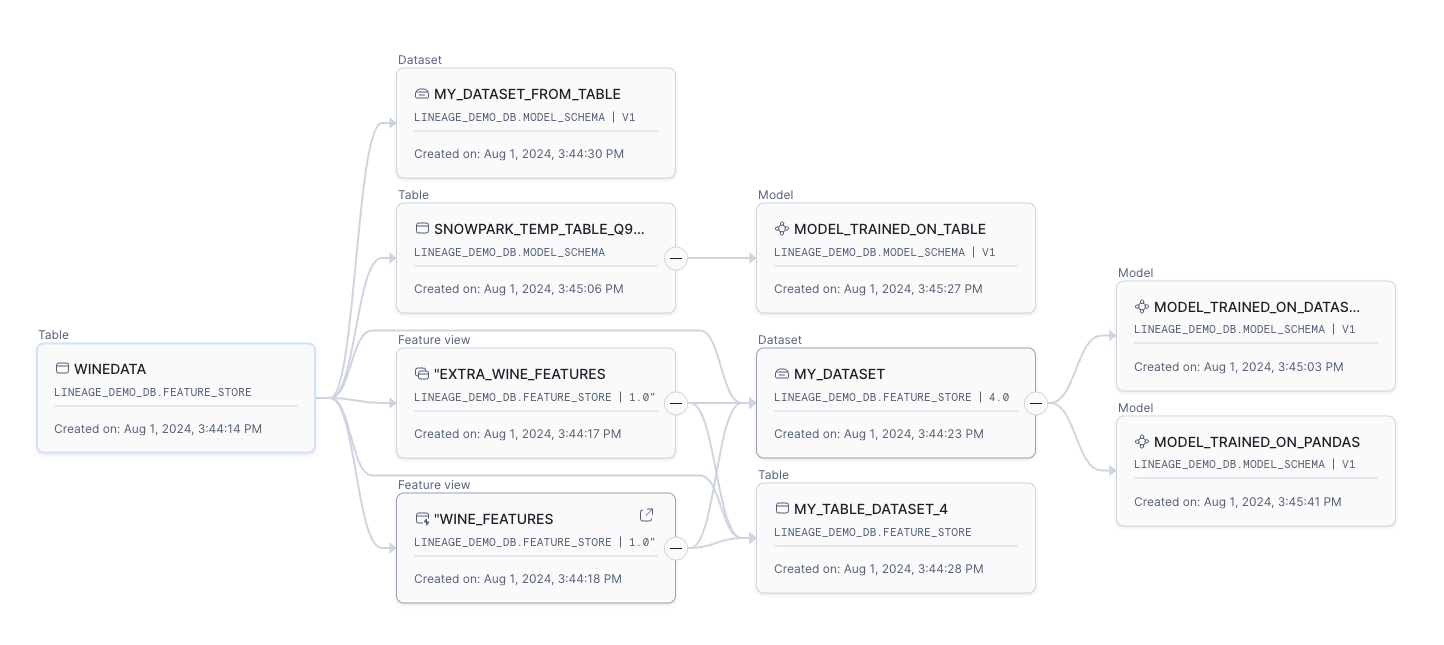

In [35]:
from IPython.display import Image, display

# Path to your image file
image_path = 'lineage-graph.png'

# Display the image
display(Image(filename=image_path,width=1000, height=1000))

<a id='clean-up-notebook'></a>


## 6. Clean up notebook  {-}


This cell will drop the schemas have been created at beginning of this notebook, and also drop all objects live in the schemas including source data tables, feature views, datasets, and models.



In [29]:
session.sql(f"DROP SCHEMA IF EXISTS {FS_DEMO_SCHEMA}").collect()
session.sql(f"DROP SCHEMA IF EXISTS {MODEL_DEMO_SCHEMA}").collect()